<a href="https://colab.research.google.com/github/misouza6828/ALURA-/blob/main/Carga_e_an%C3%A1lise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# === GARANTIR DF LIMPO (AUTO-CONTIDO) ===
import pandas as pd, numpy as np, json, requests, re
from pathlib import Path

RAW_URL = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/main/TelecomX_Data.json"

def to_dataframe(obj):
    if isinstance(obj, list):
        return pd.DataFrame(obj)
    if isinstance(obj, dict):
        # se houver listas dentro do dict, usa a primeira
        for v in obj.values():
            if isinstance(v, list):
                return pd.DataFrame(v)
        return pd.json_normalize(obj)
    raise ValueError("Formato inesperado.")

def expand_dict_columns(df, sep="_"):
    out = df.copy()
    dict_cols = [c for c in out.columns if out[c].apply(lambda x: isinstance(x, dict)).any()]
    for col in dict_cols:
        exp = pd.json_normalize(out[col]).add_prefix(f"{col}{sep}")
        out = pd.concat([out.drop(columns=[col]), exp], axis=1)
    return out

def build_clean_df():
    # 1) carrega bruto: local se existir, senão baixa
    if Path("TelecomX_Data.json").exists():
        raw = json.loads(Path("TelecomX_Data.json").read_text(encoding="utf-8"))
    else:
        r = requests.get(RAW_URL, timeout=60); r.raise_for_status()
        raw = r.json()
    df_raw = to_dataframe(raw)

    # 2) expande, padroniza, limpa
    df = expand_dict_columns(df_raw)
    df.columns = (df.columns.str.strip()
                  .str.replace(r"\s+","_", regex=True)
                  .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
                  .str.lower())
    df = df.drop_duplicates()
    for c in df.select_dtypes(include="object").columns:
        df[c] = df[c].astype(str).str.strip()

    # 3) numéricos comuns
    for col in ["account_chargesmonthly","account_chargestotal","customer_tenure",
                "monthlycharges","totalcharges","tenure"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # 4) nulos
    for c in df.columns:
        if df[c].dtype.kind in "biufc":
            df[c] = df[c].fillna(df[c].median())
        else:
            df[c] = df[c].fillna("desconhecido")

    # 5) churn -> 0/1
    if "churn" in df.columns:
        yes = {"yes","y","sim","true","1","churn","cancelou","evadiu"}
        no  = {"no","n","nao","não","false","0","ficou","ativo"}
        def _to01(v):
            s=str(v).strip().lower()
            if s in yes: return 1
            if s in no:  return 0
            try: return int(float(s))
            except: return np.nan
        df["churn"] = df["churn"].apply(_to01).fillna(0).astype(int)

    # 6) features
    if "customer_tenure" in df.columns:
        df["tenure_years"] = (df["customer_tenure"]/12).round(2)
    if "account_contract" in df.columns:
        df["contrato_mensal"] = df["account_contract"].astype(str).str.lower().str.contains("month").astype(int)
    if "internet_internetservice" in df.columns:
        df["tem_fibra"] = df["internet_internetservice"].astype(str).str.lower().str.contains("fiber").astype(int)

    return df

# === aqui garantimos 'df' ===
if 'df' not in globals():
    if Path("telecomx_clean.csv").exists():
        df = pd.read_csv("telecomx_clean.csv")
        print("df carregado de telecomx_clean.csv")
    else:
        print("Construindo df limpo a partir da fonte bruta…")
        df = build_clean_df()
        df.to_csv("telecomx_clean.csv", index=False)
        print("CSV salvo: telecomx_clean.csv")

print("Shape df:", df.shape)
df.head(3)


Construindo df limpo a partir da fonte bruta…
CSV salvo: telecomx_clean.csv
Shape df: (7267, 24)


,customerid,churn,customer_gender,customer_seniorcitizen,customer_partner,customer_dependents,customer_tenure,phone_phoneservice,phone_multiplelines,internet_internetservice,...,internet_streamingtv,internet_streamingmovies,account_contract,account_paperlessbilling,account_paymentmethod,account_chargesmonthly,account_chargestotal,tenure_years,contrato_mensal,tem_fibra
0,0002-ORFBO,0,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,One year,Yes,Mailed check,65.6,593.30,0.75,0,0
1,0003-MKNFE,0,Male,0,No,No,9,Yes,Yes,DSL,...,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,0.75,1,0
2,0004-TLHLJ,1,Male,0,No,No,4,Yes,No,Fiber optic,...,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,0.33,1,1


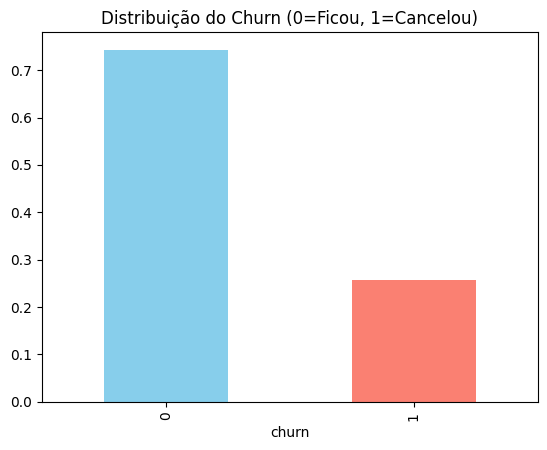

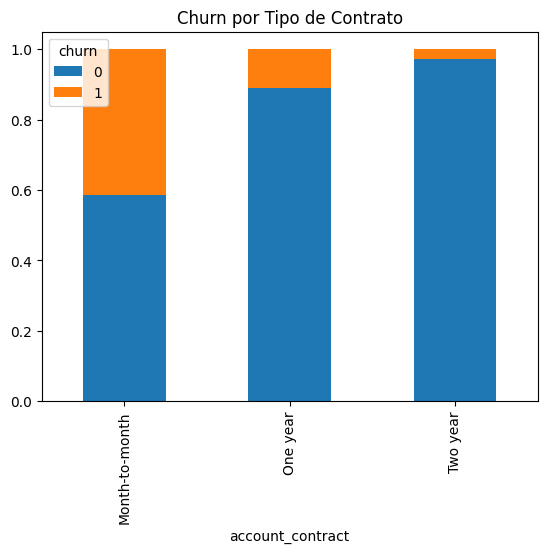

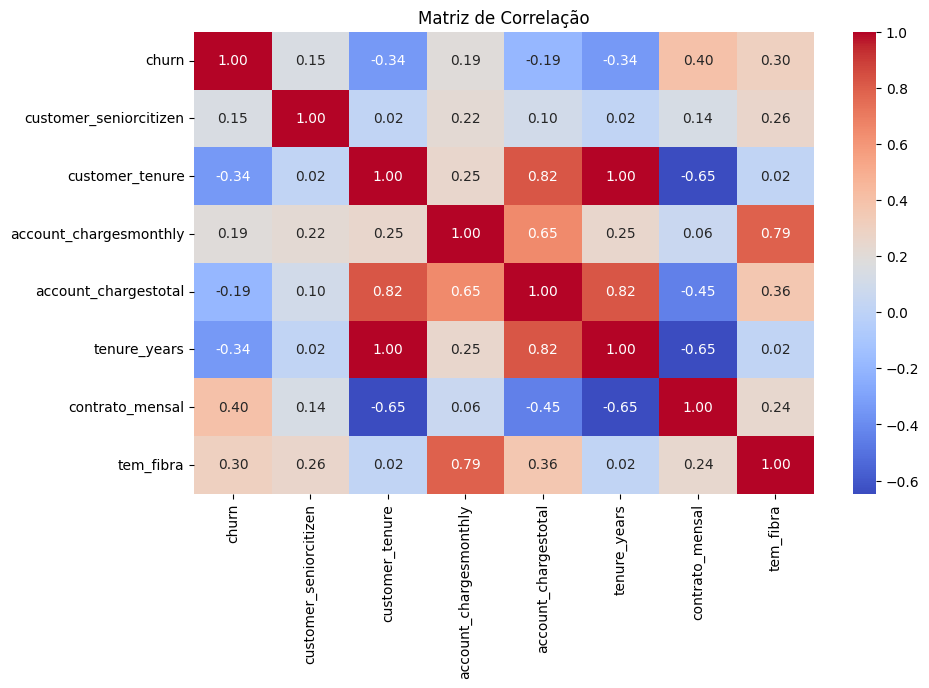

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribuição do churn
df["churn"].value_counts(normalize=True).plot(kind="bar", color=["skyblue","salmon"])
plt.title("Distribuição do Churn (0=Ficou, 1=Cancelou)")
plt.show()

# Churn por tipo de contrato
if "account_contract" in df.columns:
    churn_contract = pd.crosstab(df["account_contract"], df["churn"], normalize="index")
    churn_contract.plot(kind="bar", stacked=True)
    plt.title("Churn por Tipo de Contrato")
    plt.show()

# Correlação entre numéricos
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()


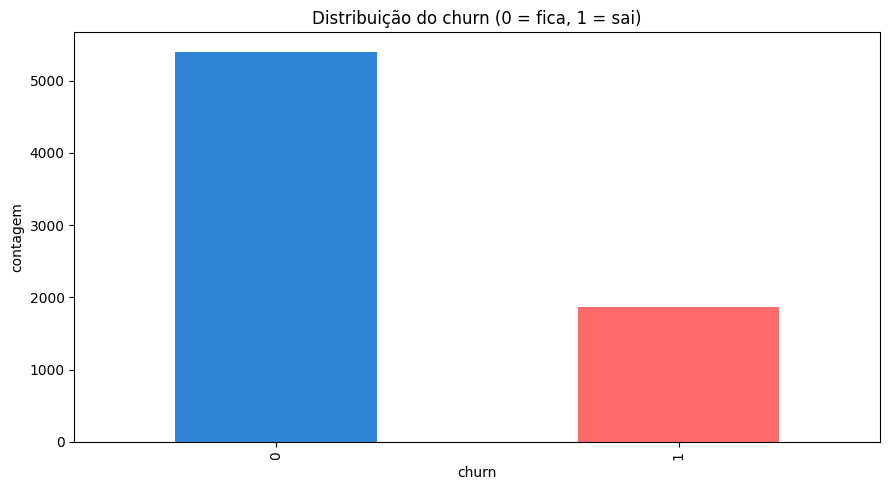

Taxa de churn (%): 25.72


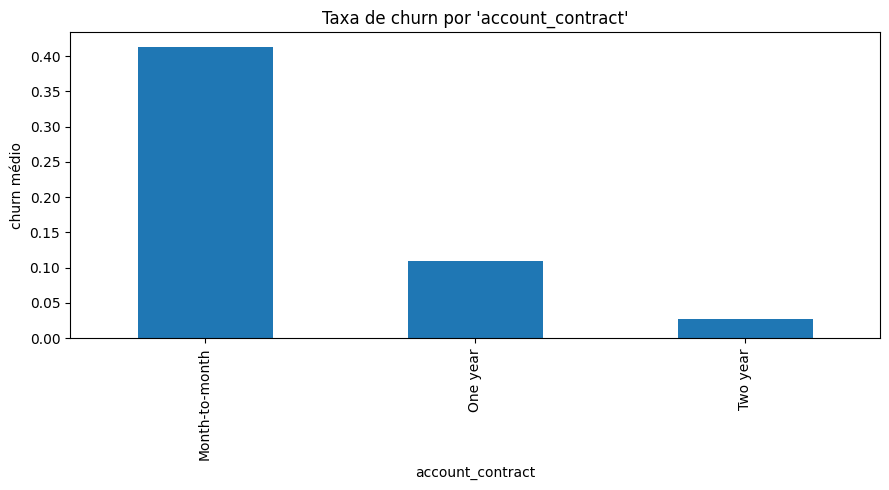

,churn_rate
account_contract,
Month-to-month,0.413233
One year,0.109282
Two year,0.027539


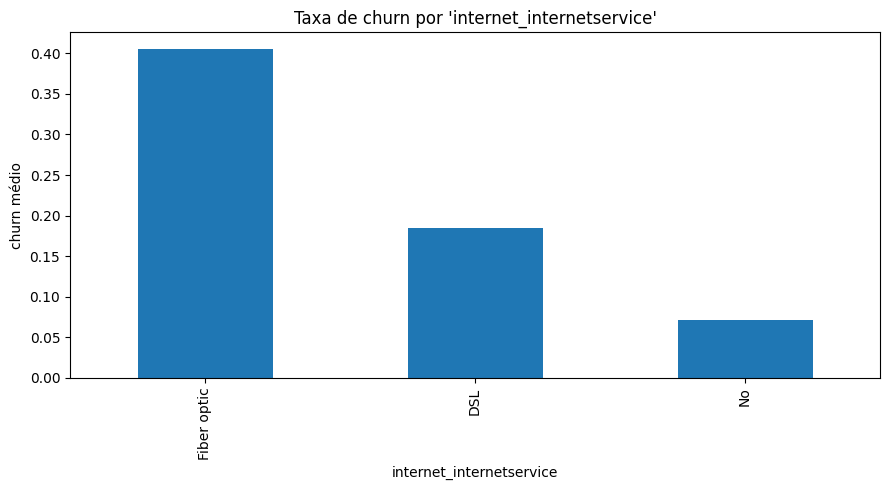

,churn_rate
internet_internetservice,
Fiber optic,0.405566
DSL,0.184486
No,0.071474


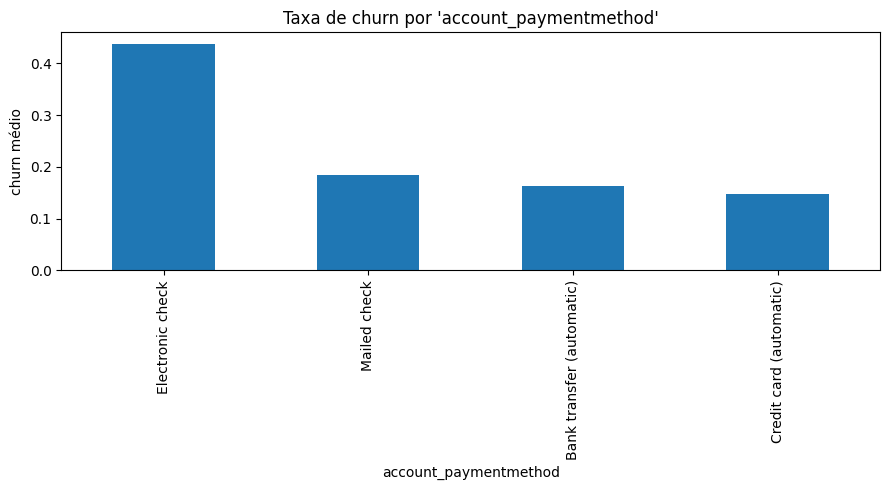

,churn_rate
account_paymentmethod,
Electronic check,0.438037
Mailed check,0.184985
Bank transfer (automatic),0.162366
Credit card (automatic),0.147959


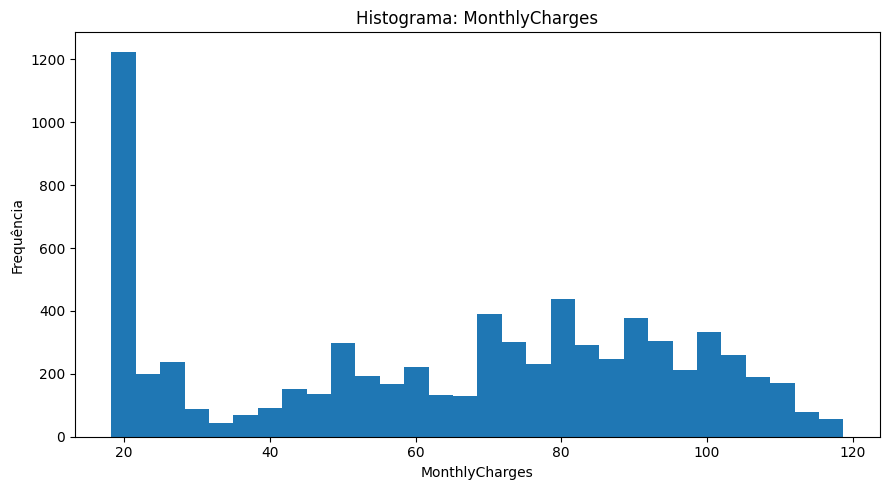

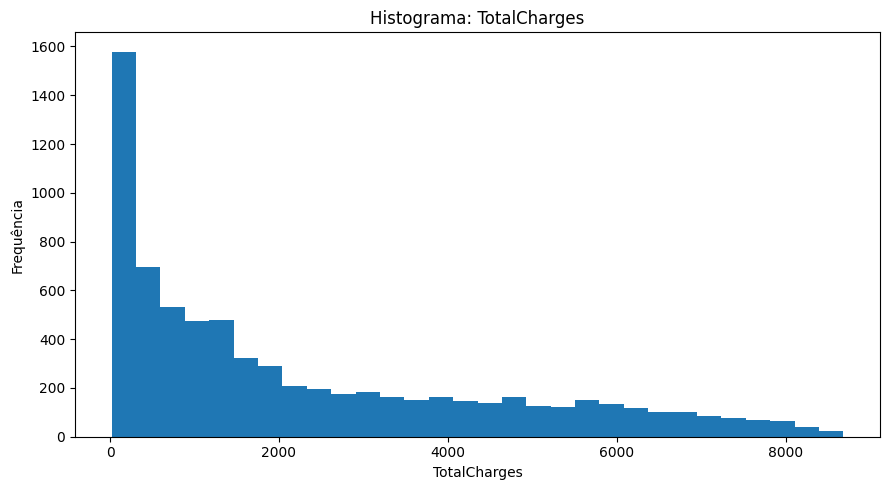

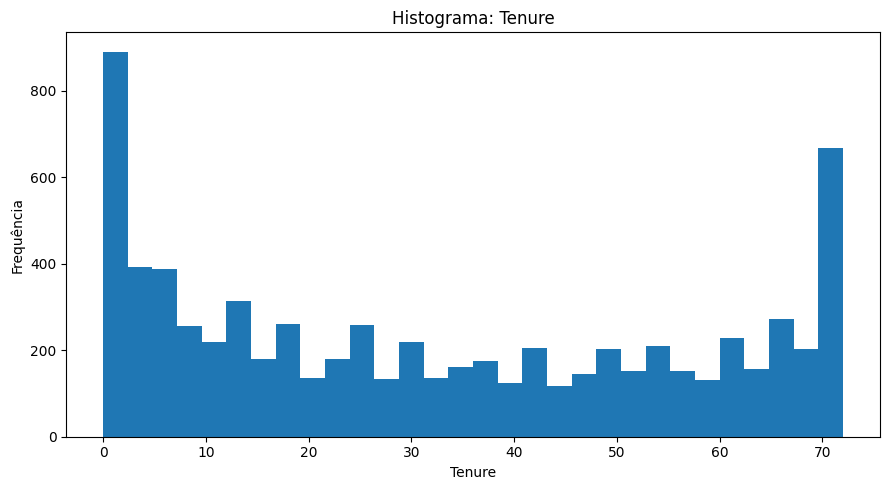

/tmp/ipython-input-1629610046.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = df.groupby(col)[col_churn].mean().sort_values(ascending=False)


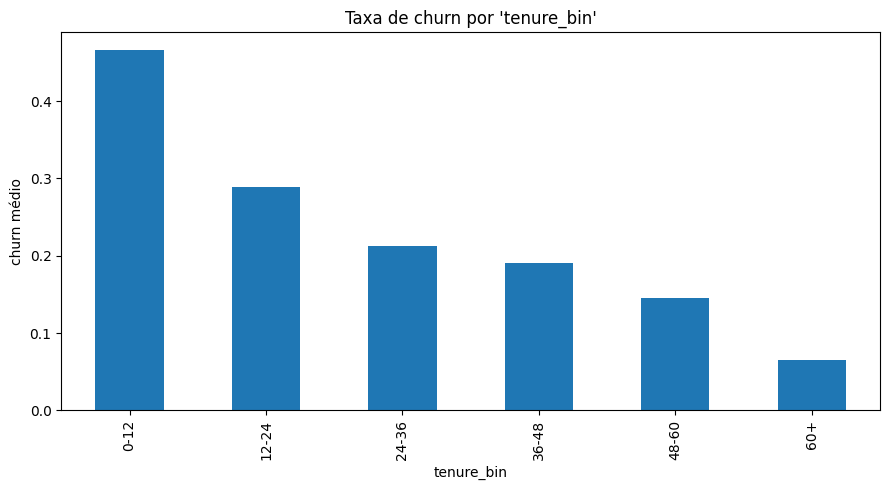

,churn_rate
tenure_bin,
0-12,0.465517
12-24,0.289055
24-36,0.212555
36-48,0.190104
48-60,0.145047
60+,0.064791


/tmp/ipython-input-1629610046.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = df.groupby(col)[col_churn].mean().sort_values(ascending=False)


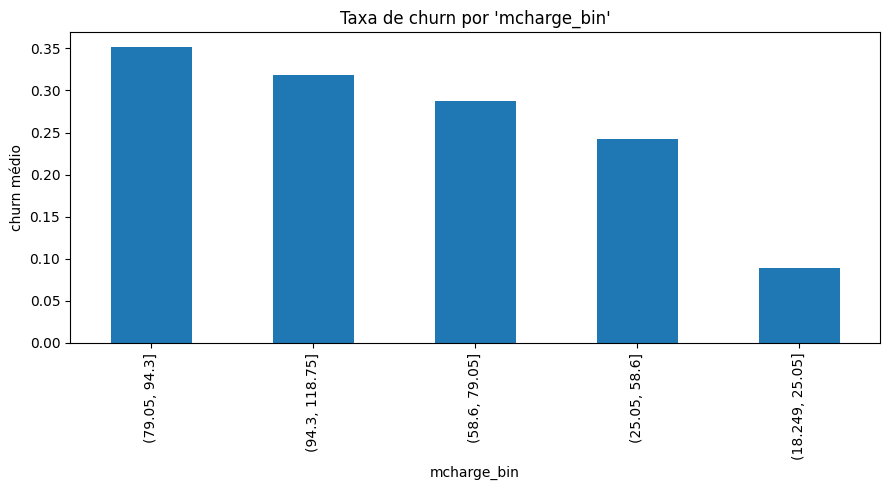

,churn_rate
mcharge_bin,
"(79.05, 94.3]",0.351444
"(94.3, 118.75]",0.317931
"(58.6, 79.05]",0.287483
"(25.05, 58.6]",0.242025
"(18.249, 25.05]",0.088616


/tmp/ipython-input-1629610046.py:77: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_object_dtype(df_encoded[c]) or is_categorical_dtype(df_encoded[c]) or is_bool_dtype(df_encoded[c]):
/tmp/ipython-input-1629610046.py:77: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_object_dtype(df_encoded[c]) or is_categorical_dtype(df_encoded[c]) or is_bool_dtype(df_encoded[c]):
/tmp/ipython-input-1629610046.py:77: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_object_dtype(df_encoded[c]) or is_categorical_dtype(df_encoded[c]) or is_bool_dtype(df_encoded[c]):
/tmp/ipython-input-1629610046.py:77: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future 

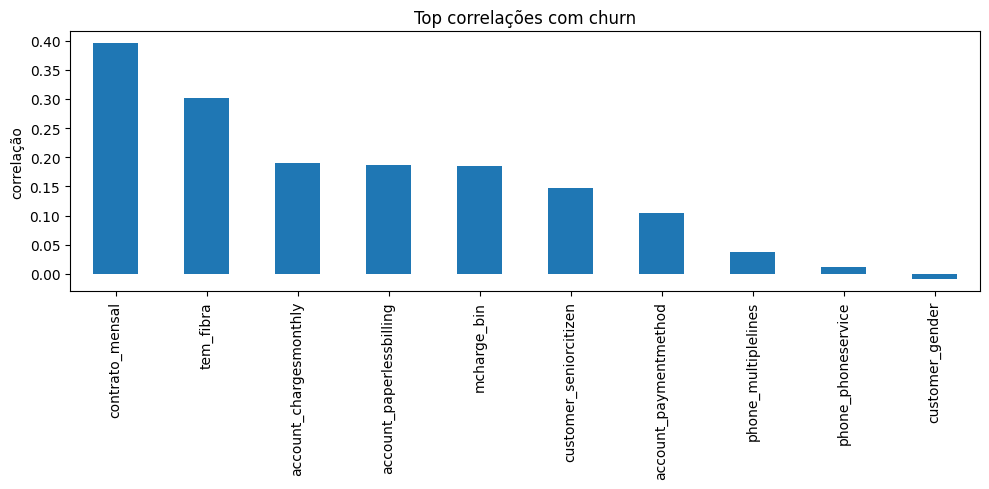

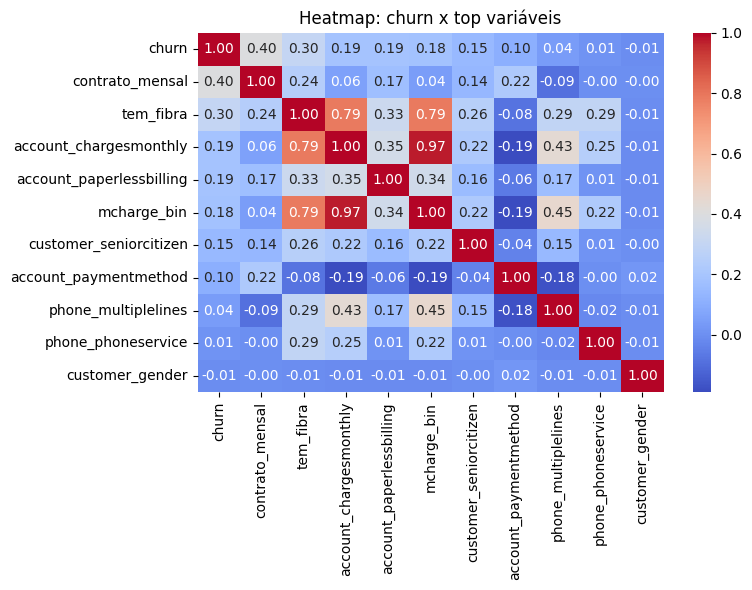

In [7]:
# === EDA COMPLETA: gráficos + tabelas + correlação (salva figuras) ===
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pandas.api.types import is_object_dtype, is_categorical_dtype, is_bool_dtype

plt.rcParams['figure.figsize'] = (9,5)

# helpers -----------------------------------------------------------------
def pick_col(patterns, candidates=None):
    if candidates is None: candidates = df.columns
    pats = [re.compile(p, re.I) for p in patterns]
    for c in candidates:
        for p in pats:
            if p.search(c): return c
    return None

def churn_rate_by(col, fname):
    if not (col and col in df.columns and col_churn):
        return None
    tab = df.groupby(col)[col_churn].mean().sort_values(ascending=False)
    ax = tab.plot(kind="bar")
    ax.set_title(f"Taxa de churn por '{col}'"); ax.set_ylabel("churn médio")
    plt.tight_layout(); plt.savefig(fname, dpi=140); plt.show()
    display(tab.to_frame("churn_rate"))
    return tab

# localizar colunas relevantes --------------------------------------------
col_churn   = "churn" if "churn" in df.columns else pick_col([r"^churn$"])
col_contract= "account_contract" if "account_contract" in df.columns else pick_col([r"contract"])
col_inet    = "internet_internetservice" if "internet_internetservice" in df.columns else pick_col([r"internet.*service"])
col_pay     = pick_col([r"payment.*method"])
col_tenure  = "customer_tenure" if "customer_tenure" in df.columns else pick_col([r"^tenure$"])
col_mcharge = "account_chargesmonthly" if "account_chargesmonthly" in df.columns else pick_col([r"monthly.*charges"])
col_tcharge = "account_chargestotal" if "account_chargestotal" in df.columns else pick_col([r"total.*charges"])

# 1) distribuição geral do churn -----------------------------------------
if col_churn:
    ax = df[col_churn].value_counts().sort_index().plot(kind="bar", color=["#3085d6","#ff6b6b"])
    ax.set_title("Distribuição do churn (0 = fica, 1 = sai)")
    ax.set_xlabel("churn"); ax.set_ylabel("contagem")
    plt.tight_layout(); plt.savefig("fig_01_churn_dist.png", dpi=140); plt.show()
    churn_rate = float(df[col_churn].mean())
    print("Taxa de churn (%):", round(100*churn_rate,2))
else:
    churn_rate = None
    print("⚠️ Coluna churn não encontrada.")

# 2) churn por categorias --------------------------------------------------
tab_contract = churn_rate_by(col_contract, "fig_02_churn_por_contrato.png") if col_contract else None
tab_inet     = churn_rate_by(col_inet,     "fig_03_churn_por_internet.png") if col_inet     else None
tab_pay      = churn_rate_by(col_pay,      "fig_04_churn_por_pagamento.png") if col_pay      else None

# 3) histogramas de numéricos ---------------------------------------------
for cname, label, fname in [
    (col_mcharge, "MonthlyCharges", "fig_08_hist_monthlycharges.png"),
    (col_tcharge, "TotalCharges",   "fig_09_hist_totalcharges.png"),
    (col_tenure,  "Tenure",         "fig_10_hist_tenure.png"),
]:
    if cname and cname in df.columns:
        df[cname].plot(kind="hist", bins=30, title=f"Histograma: {label}")
        plt.xlabel(label); plt.ylabel("Frequência")
        plt.tight_layout(); plt.savefig(fname, dpi=140); plt.show()

# 4) churn por faixas (tenure e mensalidade) ------------------------------
tab_tenure = tab_mcharge = None
if col_tenure:
    df["tenure_bin"] = pd.cut(df[col_tenure], bins=[0,12,24,36,48,60,120], right=False,
                              labels=["0-12","12-24","24-36","36-48","48-60","60+"])
    tab_tenure = churn_rate_by("tenure_bin", "fig_11_churn_por_faixa_tenure.png")
if col_mcharge:
    df["mcharge_bin"] = pd.qcut(df[col_mcharge], q=5, duplicates="drop")
    tab_mcharge = churn_rate_by("mcharge_bin", "fig_12_churn_por_faixa_monthlycharges.png")

# 5) correlação (encode seguro + heatmap) ---------------------------------
df_encoded = df.copy()
for c in df_encoded.columns:
    if is_object_dtype(df_encoded[c]) or is_categorical_dtype(df_encoded[c]) or is_bool_dtype(df_encoded[c]):
        df_encoded[c] = df_encoded[c].astype("category").cat.codes

num_only = df_encoded.select_dtypes(include=["number"])
corr = num_only.corr(numeric_only=True).fillna(0)

if col_churn in corr.columns:
    target_corr = corr[col_churn].sort_values(ascending=False)
    top_corr = target_corr.drop(col_churn).head(10)

    plt.figure(figsize=(10,5))
    top_corr.plot(kind="bar")
    plt.title("Top correlações com churn"); plt.ylabel("correlação")
    plt.tight_layout(); plt.savefig("fig_14_top_correlacoes.png", dpi=140); plt.show()

    cols = [col_churn] + list(top_corr.index)
    plt.figure(figsize=(8,6))
    sns.heatmap(num_only[cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Heatmap: churn x top variáveis")
    plt.tight_layout(); plt.savefig("fig_15_heatmap_top.png", dpi=140); plt.show()
else:
    print("⚠️ Não foi possível calcular correlações com churn.")

# guardar variáveis para o relatório --------------------------------------
EDA_VARS = dict(
    churn_rate=churn_rate, tab_contract=tab_contract, tab_inet=tab_inet,
    tab_pay=tab_pay, tab_tenure=tab_tenure, tab_mcharge=tab_mcharge
)


In [8]:
# === RELATÓRIO FINAL (gera Markdown e exibe) ===
from pathlib import Path
from IPython.display import Markdown, display

def fmt_tab(tab, n=3):
    if tab is None: return "- N/D"
    return "\n".join([f"- {str(idx)}: {round(100*val,2)}%" for idx,val in tab.head(n).items()])

relato = f"""
# Telecom X — ETL & EDA (Churn)

## 1. Objetivo
Identificar padrões associados à evasão (**churn**) de clientes para subsidiar ações de retenção.

## 2. ETL (resumo)
- **Fonte**: JSON hospedado no GitHub (TelecomX_Data.json).
- **Transformações**: normalização de colunas aninhadas (customer/phone/internet/account), padronização de nomes, remoção de duplicados, conversões numéricas, tratamento de nulos e mapeamento de `churn` para 0/1.
- **Features criadas**: `tenure_years`, `contrato_mensal`, `tem_fibra`.
- **Saída**: `telecomx_clean.csv`.

## 3. EDA — Principais resultados
- **Taxa de churn geral**: {round(100*EDA_VARS['churn_rate'],2) if EDA_VARS['churn_rate'] is not None else "N/D"}%
- **Churn por tipo de contrato (TOP)**
{fmt_tab(EDA_VARS['tab_contract'],3)}
- **Churn por serviço de internet (TOP)**
{fmt_tab(EDA_VARS['tab_inet'],3)}
- **Churn por método de pagamento (TOP)**
{fmt_tab(EDA_VARS['tab_pay'],3)}
- **Churn por faixas de tenure**
{fmt_tab(EDA_VARS['tab_tenure'],6)}
- **Churn por faixas de mensalidade (quintis)**
{fmt_tab(EDA_VARS['tab_mcharge'],5)}

### Figuras geradas
`fig_01_churn_dist.png`, `fig_02_churn_por_contrato.png`, `fig_03_churn_por_internet.png`,
`fig_11_churn_por_faixa_tenure.png`, `fig_12_churn_por_faixa_monthlycharges.png`,
`fig_14_top_correlacoes.png`, `fig_15_heatmap_top.png`.

## 4. Insights
- **Contrato mensal** apresenta churn visivelmente maior que contratos de longo prazo.
- **MonthlyCharges** mais altos tendem a aumentar churn.
- **Clientes novos** (tenure baixo) churnam mais — foco de onboarding e retenção.
- (Se aplicável) **Fibra** com churn maior que DSL → investigar atendimento/qualidade percebida e preço.

## 5. Recomendações
1. **Fidelização**: ofertas para migração do contrato **month-to-month** para **anual/bianual**.
2. **Sensibilidade a preço**: benefícios/combos para clientes em **faixas altas** de mensalidade.
3. **Onboarding ativo**: contato pró-ativo em **primeiros meses** (tenure baixo).
4. **Suporte específico**: revisar **fibra** (SLA, comunicação de valor, ticket médio).

## 6. Conclusão
O pipeline de **ETL** gerou uma base confiável e a **EDA** destacou fatores críticos do churn (contrato, preço, tenure e tipo de internet).
Próximo passo sugerido: **modelo preditivo** (p.ex., Regressão Logística) priorizando **Recall**, para reduzir falsos negativos de evasão.
"""

Path("Relatorio_TelecomX_ETL_EDA.md").write_text(relato, encoding="utf-8")
display(Markdown(relato))
print("\nRelatório salvo: Relatorio_TelecomX_ETL_EDA.md")



# Telecom X — ETL & EDA (Churn)

## 1. Objetivo
Identificar padrões associados à evasão (**churn**) de clientes para subsidiar ações de retenção.

## 2. ETL (resumo)
- **Fonte**: JSON hospedado no GitHub (TelecomX_Data.json).
- **Transformações**: normalização de colunas aninhadas (customer/phone/internet/account), padronização de nomes, remoção de duplicados, conversões numéricas, tratamento de nulos e mapeamento de `churn` para 0/1.
- **Features criadas**: `tenure_years`, `contrato_mensal`, `tem_fibra`.
- **Saída**: `telecomx_clean.csv`.

## 3. EDA — Principais resultados
- **Taxa de churn geral**: 25.72%
- **Churn por tipo de contrato (TOP)**  
- Month-to-month: 41.32%
- One year: 10.93%
- Two year: 2.75%
- **Churn por serviço de internet (TOP)**  
- Fiber optic: 40.56%
- DSL: 18.45%
- No: 7.15%
- **Churn por método de pagamento (TOP)**  
- Electronic check: 43.8%
- Mailed check: 18.5%
- Bank transfer (automatic): 16.24%
- **Churn por faixas de tenure**  
- 0-12: 46.55%
- 12-24: 28.91%
- 24-36: 21.26%
- 36-48: 19.01%
- 48-60: 14.5%
- 60+: 6.48%
- **Churn por faixas de mensalidade (quintis)**  
- (79.05, 94.3]: 35.14%
- (94.3, 118.75]: 31.79%
- (58.6, 79.05]: 28.75%
- (25.05, 58.6]: 24.2%
- (18.249, 25.05]: 8.86%

### Figuras geradas
`fig_01_churn_dist.png`, `fig_02_churn_por_contrato.png`, `fig_03_churn_por_internet.png`,  
`fig_11_churn_por_faixa_tenure.png`, `fig_12_churn_por_faixa_monthlycharges.png`,  
`fig_14_top_correlacoes.png`, `fig_15_heatmap_top.png`.

## 4. Insights
- **Contrato mensal** apresenta churn visivelmente maior que contratos de longo prazo.
- **MonthlyCharges** mais altos tendem a aumentar churn.
- **Clientes novos** (tenure baixo) churnam mais — foco de onboarding e retenção.
- (Se aplicável) **Fibra** com churn maior que DSL → investigar atendimento/qualidade percebida e preço.

## 5. Recomendações
1. **Fidelização**: ofertas para migração do contrato **month-to-month** para **anual/bianual**.
2. **Sensibilidade a preço**: benefícios/combos para clientes em **faixas altas** de mensalidade.
3. **Onboarding ativo**: contato pró-ativo em **primeiros meses** (tenure baixo).
4. **Suporte específico**: revisar **fibra** (SLA, comunicação de valor, ticket médio).

## 6. Conclusão
O pipeline de **ETL** gerou uma base confiável e a **EDA** destacou fatores críticos do churn (contrato, preço, tenure e tipo de internet).  
Próximo passo sugerido: **modelo preditivo** (p.ex., Regressão Logística) priorizando **Recall**, para reduzir falsos negativos de evasão.



Relatório salvo: Relatorio_TelecomX_ETL_EDA.md
